In [62]:
import numpy as np
import scipy.signal
import torch
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from collections import Counter
import torchaudio
import itertools
import tqdm
import torch.nn.functional as F
import scipy as sp
import torch.nn as nn
import fb

In [63]:
HYPERPARAMS = {
    "synth": {
        "N": 1032,
        "J": 58,
        "T": 32,
        "sr": 16000,
        "fmin": 64,
        "fmax": 8000,
        "batch_size": 32
    },
}

spec = HYPERPARAMS["synth"]

In [64]:
# create a random filterbank and its tightened version

w_init, w_tight = fb.random_filterbank(spec["N"], spec["J"], spec["T"], tight=True, to_torch=True)

In [65]:
synth = fb.generate_random_sine(
    spec["sr"],
    spec["fmin"],
    spec["fmax"],
    spec["N"],
    spec["batch_size"])

In [66]:
# conv1D layer with circulant boundary conditions

class TDFilterbank_real(torch.nn.Module):
    def __init__(self, spec, w_init):
        super().__init__()
        
        self.psi = torch.nn.Conv1d(
            in_channels=1,
            out_channels=spec["J"],
            kernel_size=spec["T"],
            stride=1,
            padding=0,
            bias=False)
        
        # initialize the filters to be w_init
        self.psi.weight.data = w_init[:, :spec["T"]].unsqueeze(1).float()
    
    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[-1])
        x = F.pad(x, (0, spec["T"]-1), mode='circular',)
        Wx = self.psi(x)
        Ux = torch.abs(Wx)
        return Ux
    
baseline = TDFilterbank_real(spec, w_init)
print(baseline)

TDFilterbank_real(
  (psi): Conv1d(1, 58, kernel_size=(32,), stride=(1,), bias=False)
)


In [67]:
# loss functions with penalization terms

# penalizing large kappa

class KappaLoss(nn.Module):
    def __init__(self):
        super(KappaLoss, self).__init__()
        self.loss = nn.MSELoss()

    def forward(self, inputs, targets, w):
        w = torch.cat((w,torch.zeros([spec["J"], spec["N"]-spec["T"]])),dim=1)
        w_hat = torch.sum(torch.abs(torch.fft.fft(w,dim=1))**2,dim=0)
        Lam_max = torch.max(w_hat,dim=0).values
        Lam_min = torch.min(w_hat,dim=0).values
        loss = torch.mean(self.loss(inputs, targets)) + 0.0001*Lam_max/Lam_min
        return loss
    
# penalizing large ||S - I||^2
    
class SLoss(nn.Module):
   def __init__(self):
       super(SLoss, self).__init__()

   def forward(self, inputs, targets, w):
       w = torch.cat((w,torch.zeros([spec["J"], spec["N"]-spec["T"]])),dim=1)
       W = fb.circulant(w)
       S = torch.matmul(W.T,W)
       I = torch.eye(S.shape[0])
       loss = torch.mean(torch.abs(inputs - targets)**2) + 0.001*torch.norm(S-I)**2
       return loss
    
# penalizing large ||diag(S) - I||^2
    
class DiagSLoss(nn.Module):
    def __init__(self):
        super(DiagSLoss, self).__init__()

    def forward(self, inputs, targets, w):
        S = fb.S_diag(w)
        loss = torch.mean(torch.abs(inputs - targets)**2) + 0.01*torch.norm(S-1)**2
        return loss

In [68]:
# training function

def train(baseline, penalization, lr, n_epochs, epoch_size):
    optimizer = torch.optim.Adam(baseline.parameters(), lr=lr)
    mse = torch.nn.MSELoss()
    if penalization == 'mse':
        criterion = torch.nn.MSELoss() 
    if penalization == 'kappa':
        criterion = KappaLoss() 
    if penalization == 'S':
        criterion = SLoss() 
    if penalization == 'diagS':
        criterion = DiagSLoss() 
    losses = []
    conditions = []

    w = baseline.psi.weight.detach().numpy()[:,0,:]
    w = np.concatenate((w,np.zeros([spec["J"], spec["N"]-spec["T"]])),axis=1)
    A,B = fb.frame_bounds_lp(w)
    conditions.append(B/A)

    running_loss = 0.0
    for _ in range(epoch_size):
        inputs = next(synth)
        outputs = baseline(inputs)
        targets = fb.filterbank_response(inputs, w_tight, mag=True)
        w = baseline.psi.weight[:,0,:]
        loss = mse(outputs, targets)
        running_loss += loss.item()
    print(1000 * running_loss)
    losses.append(running_loss)

    for _ in range(n_epochs):
        running_loss = 0.0
        for i in tqdm.tqdm(range(epoch_size)):
            inputs = next(synth)
            optimizer.zero_grad()
            outputs = baseline(inputs)
            targets = fb.filterbank_response(inputs, w_tight, mag=True)
            if penalization == 'mse':
                loss = mse(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            if penalization == 'kappa':
                w = baseline.psi.weight[:,0,:]
                loss = criterion(outputs, targets, w)
                loss.backward()
                optimizer.step()
                loss2 = mse(outputs, targets)
                running_loss += loss2.item()
            if penalization == 'S' or penalization == 'diagS':
                # use this loss only every 10th iteration
                if np.mod(i,10) == 0:
                    w = baseline.psi.weight[:,0,:]
                    loss = criterion(outputs, targets, w)
                    loss.backward()
                    optimizer.step()
                else:
                    loss = mse(outputs, targets)
                    loss.backward()
                    optimizer.step()                
                    loss2 = mse(outputs, targets)
                    running_loss += loss2.item()
        losses.append(running_loss)
        w = baseline.psi.weight.detach().numpy()[:,0,:]
        w = np.concatenate((w,np.zeros([spec["J"], spec["N"]-spec["T"]])),axis=1)
        A,B = fb.frame_bounds_lp(w)
        conditions.append(B/A)
        print(1000 * running_loss)

    return losses, conditions

In [69]:
n_epochs = 10
epoch_size = 50
lr = 0.0001

In [70]:
baseline = TDFilterbank_real(spec, w_init)
losses_mse, conditions_mse = train(
    baseline=baseline,
    penalization='mse',
    lr=lr,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

baseline = TDFilterbank_real(spec, w_init)
losses_kappa, conditions_kappa = train(
    baseline=baseline,
    penalization='kappa',
    lr=lr,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

# baseline = TDFilterbank_real(spec, w_init)
# losses_fo, conditions_fo = train(
#     baseline=baseline,
#     penalization='diagS',
#     lr=lr,
#     n_epochs=n_epochs,
#     epoch_size=epoch_size)

2.104402610711986


100%|██████████| 50/50 [00:04<00:00, 11.67it/s]


0.7455928198396577


100%|██████████| 50/50 [00:04<00:00, 12.25it/s]


0.4615361817741359


100%|██████████| 50/50 [00:06<00:00,  7.43it/s]


0.45323690346776857


100%|██████████| 50/50 [00:08<00:00,  6.23it/s]


0.44555234899235074


100%|██████████| 50/50 [00:07<00:00,  6.86it/s]


0.445224693066848


100%|██████████| 50/50 [00:07<00:00,  6.88it/s]


0.43306649013175047


100%|██████████| 50/50 [00:06<00:00,  7.72it/s]


0.4426173159117752


100%|██████████| 50/50 [00:05<00:00,  9.70it/s]


0.4406997140904423


100%|██████████| 50/50 [00:04<00:00, 10.95it/s]


0.4467651679078699


100%|██████████| 50/50 [00:04<00:00, 11.04it/s]


0.4313992471907113
2.0610950869013323


100%|██████████| 50/50 [00:06<00:00,  7.44it/s]


0.7885420027378132


100%|██████████| 50/50 [00:05<00:00,  8.34it/s]


0.6407404935089289


100%|██████████| 50/50 [00:06<00:00,  7.46it/s]


0.667477289425733


100%|██████████| 50/50 [00:10<00:00,  4.62it/s]


0.6154428892841679


100%|██████████| 50/50 [00:07<00:00,  6.36it/s]


0.647152870442369


100%|██████████| 50/50 [00:06<00:00,  8.15it/s]


0.6697975486531504


100%|██████████| 50/50 [00:10<00:00,  4.59it/s]


0.6356809853969025


100%|██████████| 50/50 [00:07<00:00,  6.25it/s]


0.6289269085755222


100%|██████████| 50/50 [00:10<00:00,  4.79it/s]


0.6605453254451277


100%|██████████| 50/50 [00:07<00:00,  6.69it/s]

0.6446102643167251


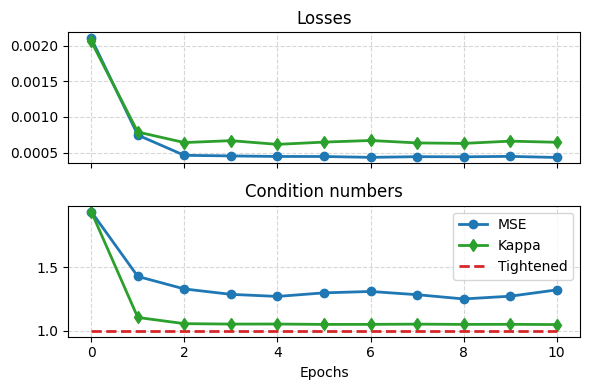

In [71]:
# plot losses and condition numbers over epochs

plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
Ts = np.arange(0, n_epochs+1)

ax = axes[0]
ax.plot(Ts, losses_mse, 'tab:blue', linewidth=2, marker = 'o')
ax.plot(Ts, losses_kappa, 'tab:green', linewidth=2, marker = 'd')
# ax.plot(Ts, losses_fo, 'tab:orange', linewidth=2, marker = 's')

ax.set_title('Losses')
ax.grid(linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(Ts, conditions_mse, 'tab:blue', linewidth=2, label='MSE', marker = 'o')
ax.plot(Ts, conditions_kappa, 'tab:green', linewidth=2, label='Kappa', marker = 'd')
# ax.plot(Ts, conditions_fo, 'tab:orange', linewidth=2, label='Frameoperator', marker = 's')
ax.plot(Ts, np.ones(len(Ts)), 'tab:red', linewidth=2, label='Tightened', linestyle='--')

ax.set_title('Condition numbers')
ax.legend(loc='upper right')
ax.set_xlabel('Epochs')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('Reproducing_Random_Tightness.pdf', bbox_inches='tight')

In [72]:
# save w_init and w_tight_fir as input for the next notebook
w_tight_fir = baseline.psi.weight.detach().numpy()[:,0,:]
w_tight_fir = np.concatenate((w_tight_fir,np.zeros([spec["J"], spec["N"]-spec["T"]])),axis=1)
np.save('w_init.npy', w_init)
np.save('w_tight_fir.npy', w_tight_fir)